# Shuffle DP Laplace Mechanism under Poisoning Attack (Mean Estimation)

This notebook evaluates the robustness of Shuffle Differential Privacy (Shuffle DP) in estimating the **mean** using the Laplace mechanism. The true local \( \varepsilon_0 \) is derived from a target amplified privacy \( \varepsilon' = 1.0 \) using a tight privacy amplification bound.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Parameters
n = 10000
epsilon_prime = 1.0
delta = 1e-5
beta = 0.5
mu = 1.0
gamma_values = np.linspace(0, 0.3, 5)
num_trials = 5

# Compute true epsilon_0 from amplification formula
def compute_true_epsilon(epsilon_prime, beta, delta, n):
    def loss(eps0):
        p = np.exp(eps0)
        rhs = np.sqrt((beta * (p - 1) * np.log(1 / delta)) / n)
        return (rhs - epsilon_prime) ** 2
    result = minimize_scalar(loss, bounds=(0.01, 10), method='bounded')
    return result.x

epsilon = compute_true_epsilon(epsilon_prime, beta, delta, n)

# Simulation

def simulate_sdp_mean(n, epsilon, gamma, attack_type, dist_sampler):
    scale = 1 / epsilon
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt

    honest_data = dist_sampler(n_honest)

    if attack_type == "OPA":
        poison_value = 1 + 5 / epsilon  # max attack value
        corrupt_data = np.full(n_corrupt, poison_value)
    elif attack_type == "IPA":
        corrupt_data = np.ones(n_corrupt)

    combined_data = np.concatenate([honest_data, corrupt_data])
    noisy_data = combined_data + np.random.laplace(scale=scale, size=n)
    return np.mean(noisy_data)

# Run experiment

def run_sdp_mean_experiment(dist_sampler):
    results = {"OPA": [], "IPA": []}
    for gamma in gamma_values:
        for attack in ["OPA", "IPA"]:
            trials = [simulate_sdp_mean(n, epsilon, gamma, attack, dist_sampler) for _ in range(num_trials)]
            mean = np.mean(trials)
            std = np.std(trials)
            results[attack].append((gamma, mean, mean - 2 * std, mean + 2 * std))
    return results

# Plotting

def plot_sdp_mean_results(results, title, baseline_mean):
    plt.figure(figsize=(8, 5))
    for attack, color in zip(["OPA", "IPA"], ["red", "blue"]):
        arr = np.array(results[attack])
        plt.plot(arr[:, 0], arr[:, 1], marker='o', label=attack, color=color)
        plt.fill_between(arr[:, 0], arr[:, 2], arr[:, 3], color=color, alpha=0.2)
    plt.axhline(baseline_mean, color='black', linestyle='--', label='True Mean')
    plt.xlabel("Corruption Ratio γ")
    plt.ylabel("Estimated Mean")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

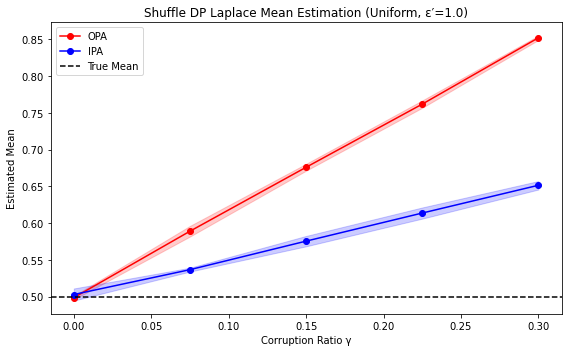

In [2]:
# Uniform[0,1] Distribution
np.random.seed(42)
uniform_sampler = lambda n: np.random.uniform(0, 1, size=n)
baseline_mean_uniform = 0.5
results_uniform = run_sdp_mean_experiment(uniform_sampler)
plot_sdp_mean_results(results_uniform, "Shuffle DP Laplace Mean Estimation (Uniform, ε′=1.0)", baseline_mean_uniform)

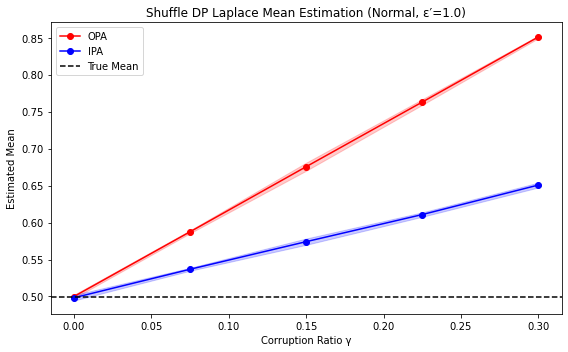

In [3]:
# Normal[0.5, 0.1^2] Distribution
normal_sampler = lambda n: np.clip(np.random.normal(loc=0.5, scale=0.1, size=n), 0, 1)
baseline_mean_normal = np.mean(normal_sampler(100000))
results_normal = run_sdp_mean_experiment(normal_sampler)
plot_sdp_mean_results(results_normal, "Shuffle DP Laplace Mean Estimation (Normal, ε′=1.0)", baseline_mean_normal)

## Conclusion

This notebook demonstrates the vulnerability of Shuffle DP-based mean estimation under poisoning.

**Findings:**
- **OPA** has the strongest effect, especially with large injected values relative to the real data range.
- **IPA** has smaller but noticeable effect when raw inputs are pushed toward the upper bound.
- Shuffle DP mitigates IPA more effectively than LDP due to centralized noise addition, but remains susceptible to OPA unless attacker injection is constrained.

Realistic deployments should consider enforcing bounded input preprocessing and monitoring submission behavior to guard against poisoning attacks.

# Shuffle DP Laplace Mechanism under Poisoning Attack (Variance Estimation)

This notebook further evaluates the robustness of Shuffle Differential Privacy (Shuffle DP) in estimating the **variance** using the Laplace mechanism. The true local \( \varepsilon_0 \) is computed from the desired \( \varepsilon' = 1.0 \) using a tight amplification formula.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Parameters
n = 10000
epsilon_prime = 1.0
delta = 1e-5
beta = 0.5
gamma_values = np.linspace(0, 0.3, 5)
num_trials = 5

# Compute true epsilon from amplification formula
def compute_true_epsilon(epsilon_prime, beta, delta, n):
    def loss(eps0):
        p = np.exp(eps0)
        rhs = np.sqrt((beta * (p - 1) * np.log(1 / delta)) / n)
        return (rhs - epsilon_prime) ** 2
    result = minimize_scalar(loss, bounds=(0.01, 10), method='bounded')
    return result.x

epsilon = compute_true_epsilon(epsilon_prime, beta, delta, n)

# Simulation

def simulate_sdp_variance(n, epsilon, gamma, attack_type, dist_sampler):
    scale = 1 / epsilon
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt

    honest_data = dist_sampler(n_honest)

    if attack_type == "OPA":
        poison_value = 1 + 5 / epsilon
        corrupt_data = np.full(n_corrupt, poison_value)
    elif attack_type == "IPA":
        corrupt_data = np.ones(n_corrupt)

    combined_data = np.concatenate([honest_data, corrupt_data])
    noisy_data = combined_data + np.random.laplace(scale=scale, size=n)
    return np.var(noisy_data)

# Run experiment

def run_sdp_variance_experiment(dist_sampler):
    results = {"OPA": [], "IPA": []}
    for gamma in gamma_values:
        for attack in ["OPA", "IPA"]:
            trials = [simulate_sdp_variance(n, epsilon, gamma, attack, dist_sampler) for _ in range(num_trials)]
            mean = np.mean(trials)
            std = np.std(trials)
            results[attack].append((gamma, mean, mean - 2 * std, mean + 2 * std))
    return results

# Plotting

def plot_sdp_variance_results(results, title, baseline_var):
    plt.figure(figsize=(8, 5))
    for attack, color in zip(["OPA", "IPA"], ["red", "blue"]):
        arr = np.array(results[attack])
        plt.plot(arr[:, 0], arr[:, 1], marker='o', label=attack, color=color)
        plt.fill_between(arr[:, 0], arr[:, 2], arr[:, 3], color=color, alpha=0.2)
    plt.axhline(baseline_var, color='black', linestyle='--', label='True Variance')
    plt.xlabel("Corruption Ratio γ")
    plt.ylabel("Estimated Variance")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


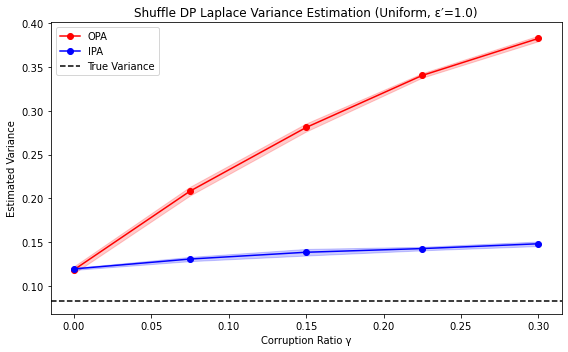

In [5]:

# Uniform[0,1] Distribution
np.random.seed(42)
uniform_sampler = lambda n: np.random.uniform(0, 1, size=n)
baseline_variance_uniform = 1 / 12
results_uniform = run_sdp_variance_experiment(uniform_sampler)
plot_sdp_variance_results(results_uniform, "Shuffle DP Laplace Variance Estimation (Uniform, ε′=1.0)", baseline_variance_uniform)



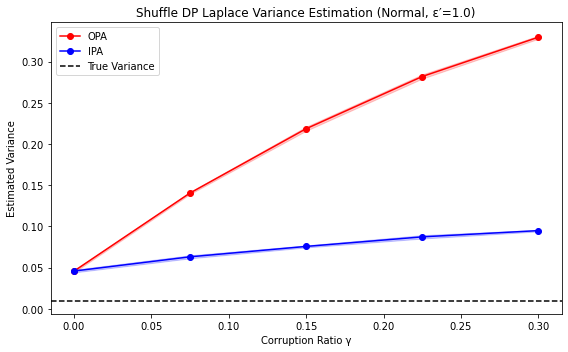

In [6]:
# Normal[0.5, 0.1^2] Distribution
normal_sampler = lambda n: np.clip(np.random.normal(loc=0.5, scale=0.1, size=n), 0, 1)
baseline_variance_normal = np.var(normal_sampler(100000))
results_normal = run_sdp_variance_experiment(normal_sampler)
plot_sdp_variance_results(results_normal, "Shuffle DP Laplace Variance Estimation (Normal, ε′=1.0)", baseline_variance_normal)


## Conclusion

This notebook evaluates the impact of poisoning attacks on Shuffle DP-based variance estimation using the Laplace mechanism.

**Findings:**
- Shuffle DP reduces the effect of IPA due to centralized noise, especially in low-corruption settings.
- OPA remains a powerful attack vector by injecting large values, inflating the output variance.
- Normal input distributions yield tighter bounds, while Uniform exposes more vulnerability.

Further work may consider restricting input ranges, bounding contributions, or introducing consistency checks before aggregation.
